# Laura_Cavenati_864000_assignment1

## Introduction

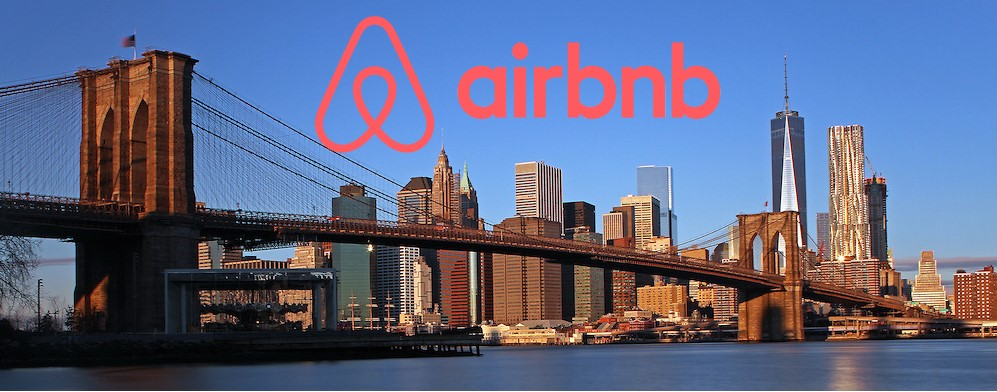


Airbnb is an online marketplace for arranging or offering lodging, primarily homestays, or tourism experiences since 2008. The company does not own any of the real estate listings, nor does it host events; it acts as a broker, receiving commissions from each booking. The company is based in San Francisco, California, United States.  
NYC is the most populous city in the United States and also one of the most popular tourism and business place in the world.

The goal of this work consists in the prediction of the price of a private room/entire apartment in New York City using a neural network. Meanwhile, price feature's relationship examines with others and some data exploratory analysis will be made.

The dataset includes the information about hosts, geographic availability, and necessary metrics of Airbnb apartments in New York City in 2019.


## Import Libraries

In [1]:
from keras import *
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.layers import Activation, LeakyReLU
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from sklearn.preprocessing import StandardScaler
import os 
import statistics
import seaborn as sns
import math

## Utility functions

In [2]:
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

def print_evaluate(true, predicted):  
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    print('RMSE:', rmse)

## Set folder

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MAGISTRALE/2 anno/1 semestre/advanced machine learning')
train_folder = "Assignment 1/"

Mounted at /content/drive


## Import Data

In [4]:
X_train = pd.read_csv(train_folder+"X_train.csv")
X_test = pd.read_csv(train_folder+"X_test.csv")
y_train = pd.read_csv(train_folder+"y_train.csv")

## Preprocessing of Data

In [5]:
print('X_train dimension:', X_train.shape)
print('X_test dimension: ', X_test.shape)
X_train.dtypes  #checking type of every column in the dataset

X_train dimension: (33884, 10)
X_test dimension:  (3765, 10)


Unnamed: 0                          int64
latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
Private_room                        int64
Entire_home/apt                     int64
dtype: object

This dataset has around 37649 observations in it (33884 in the train set, 3765 in the test set) with 10 columns (9 + index), all with numeric values.

In [6]:
#change the index column
X_train.set_index('Unnamed: 0', inplace=True)
y_train.set_index('Unnamed: 0', inplace=True)
X_test.set_index('Unnamed: 0', inplace=True)

In [7]:
X_train.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
count,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000
mean,393.742123,-767.324528,7.109904,23.391778,1.095455,7.101080,112.995839,0.456085,0.520127
std,3773.366411,7123.758128,20.234836,44.608022,1.610452,32.746915,131.641035,0.498075,0.499602
min,40.499790,-74142.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,40.690427,-73.983503,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000
50%,40.723645,-73.956025,3.000000,5.000000,0.370000,1.000000,45.000000,0.000000,1.000000
75%,40.763910,-73.937005,5.000000,24.000000,1.590000,2.000000,227.000000,1.000000,1.000000
max,40894.000000,-73.712990,1000.000000,629.000000,58.500000,327.000000,365.000000,1.000000,1.000000


In [8]:
X_test.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
count,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000
mean,397.429772,-623.385344,7.717663,22.546348,1.073421,8.124568,115.432669,0.451262,0.526959
std,3793.819578,6348.269973,31.688428,42.644924,1.553516,37.043267,132.790393,0.497685,0.499339
min,40.507080,-74124.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,40.689430,-73.984260,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000
50%,40.723370,-73.956270,2.000000,5.000000,0.380000,1.000000,51.000000,0.000000,1.000000
75%,40.763420,-73.935150,5.000000,24.000000,1.550000,2.000000,231.000000,1.000000,1.000000
max,40833.000000,-73.724350,1250.000000,447.000000,20.940000,327.000000,365.000000,1.000000,1.000000


There is clearly an error in the latitude and longitude values, (the latitude of New York City, USA is 40.730610, and the longitude is -73.935242), probably due to encoding.
So I change these values from X_train and X_test.

In [9]:
X_train['latitude'] = X_train['latitude'].where(X_train['latitude'] < 41, X_train['latitude']/1000)
X_train['longitude'] = X_train['longitude'].where(X_train['longitude'] >-80, X_train['longitude']/1000)

X_test['latitude'] = X_test['latitude'].where(X_test['latitude'] < 41, X_test['latitude']/1000)
X_test['longitude'] = X_test['longitude'].where(X_test['longitude'] >-80, X_test['longitude']/1000)

In [10]:
y_train.describe()

,price
count,33884.000000
mean,153.605389
std,249.102710
min,0.000000
25%,69.000000
50%,106.000000
75%,175.000000
max,10000.000000


In [11]:
print('number of lines with price 9999 or 10000:', y_train[(y_train.price == 9999) | (y_train.price == 10000)].count()[0])

number of lines with price 9999 or 10000: 5


There is an error in the prices as some of them reach values equal to 9999 and 10000.   
So I remove these 5 lines with these values from X_train and y_train.

In [12]:
delindexprice=y_train[(y_train.price == 9999) | (y_train.price == 10000)].index
y_train.drop(delindexprice, inplace=True)
X_train.drop(delindexprice, inplace=True)

Looking to find out what columns have null values.   
We find that there are no null values.

In [13]:
X_train.isnull().sum()  #The 'sum' function will show us how many nulls are found in each column in dataset. 

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
Private_room                      0
Entire_home/apt                   0
dtype: int64

## Descriptive and exploratory Analysis

Now we explore the distribution of the data.



In [14]:
plt.figure(figsize=(20, 20))
sns.pairplot(X_train, diag_kind="hist", height=5)

Output hidden; open in https://colab.research.google.com to view.

Latitude and longitude have a normal distribution, most of the hosts are concetrated in specific area.  
Reviews_per_month has two outlayers.  
The most of the hosts are not available all the year.  

Now I display the area subject to analysis.

In [15]:
import folium
m=folium.Map([40.7128,-74.0060],zoom_start=11)
display(m)

Now I analize the target variable price.

In [16]:
print(f"Average of price per night : ${y_train.price.mean():.2f}")
print(f"Maximum price per night : ${y_train.price.max()}")
print(f"Minimum price per night : ${y_train.price.min()}")
y_train[y_train.price == 0].count()[0]

Average of price per night : $152.15
Maximum price per night : $8500
Minimum price per night : $0


8

It's very strange, there are 8 free private room/apartment!  
There are outliers in the price target variables. We should ask a domain expert for information on how to deal with these values.  


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Price Distribution Plot')

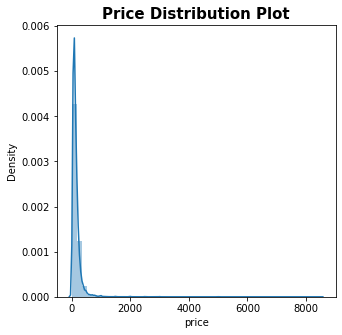

In [17]:
plt.figure(figsize=(5,5))
sns.distplot(y_train['price'])
plt.title("Price Distribution Plot",size=15, weight='bold')

The above graph shows that prices are not normally distributed as well as there is a lot of noise. There is a positive skewness so log transformation will be used to make this feature less skewed. This will help to make easier interpretation and better analysis.  
Since division by zero is a problem, log+1 transformation would be better.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Log-Price Distribution Plot')

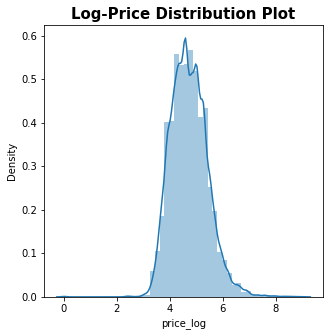

In [18]:
def logaritmo(riga):
  return math.log(riga['price']+1)

y_train['price_log']=y_train.apply(logaritmo, axis=1)

plt.figure(figsize=(5, 5))
sns.distplot(y_train['price_log'])
plt.title("Log-Price Distribution Plot", size=15, weight='bold')


With help of log transformation, now price feature have normal distribution.  
I visualize all NYC listings using latitude and longitude points. I added a color-coded range for each point on the map based on the log-price of the listing.

No handles with labels found to put in legend.


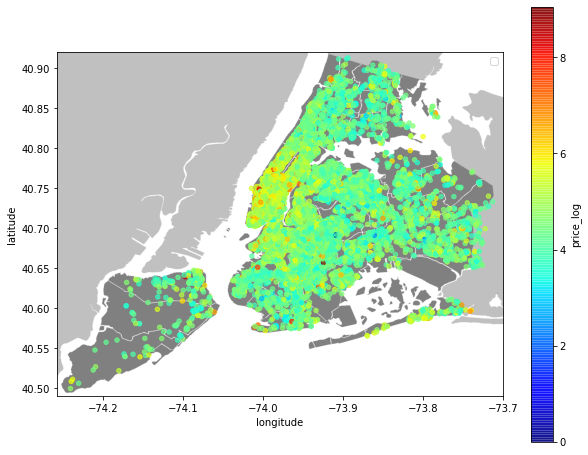

In [19]:
X=pd.merge(X_train, y_train, left_on='Unnamed: 0', right_on='Unnamed: 0')

import urllib
plt.figure(figsize=(10,8))
#loading the png NYC image found on Google and saving to my local folder along with the project
i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
nyc_img=plt.imread(i)
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

X.plot(kind='scatter', x='longitude', y='latitude',  c='price_log', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.7, zorder=5)

plt.legend()
plt.show()

The above graph shows that there is a correlation between geographic location of the apartment and price; Brooklyn and Manhattan are the groups with the highest median prices. 

# Model Using Keras

In [20]:
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Activation

I split the dataset in train and validation set.

In [21]:
del y_train['price_log']
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Even if data has not a normal distribution, I standardize data so they have a mean of zero and a standard deviation of
one. I could have normalized them in a range [0, 1] but this transformation wouldn't handle outliers well.  
(The mean and standard deviation are computed from the training data. The validation and test data have been standardized using the statistics computed from the training data.)

In [22]:
X_trainst, scaler1 = preprocess_data(X_train)
X_validationst, _ = preprocess_data(X_validation, scaler1)

X_testst, _ = preprocess_data(X_test, scaler1)

y_trainst, scaler2 = preprocess_data(y_train)
y_validationst, _ = preprocess_data(y_validation, scaler2) 

### Model 1

Now I built a Neural Network model starting from a simple model with an input layer, one hidden layer and one output layer. The number of neurons that make up the input layer equals the number of features in the data, 9.  
Neural Network is a regressor so the output leyer has a single node.  
As activation function in the input and hidden layer I will begin with using ReLU function and then move over to other activation functions.  
In the output layer I don't use an output function because values are not limited.  

I adopt mean of squared error as a loss function, stocastis gradient descent as optimizer and root mean squared error as metrics.

In [23]:
n_outputs=y_train.shape[1]
inputs = Input(shape = (X_train.shape[1])) #T/X/Y/C)
x = layers.Dense(10, activation = 'relu') (inputs)
x = layers.Dense(n_outputs) (x)
model1 = Model(inputs, x)
model1.compile(loss = 'mse', optimizer='sgd', metrics = [tf.keras.metrics.RootMeanSquaredError()])
result1=model1.fit(X_trainst, y_trainst, batch_size=100, epochs=30, verbose=0,
          validation_data=(X_validationst, y_validationst))

In [24]:
print('RMSE:', result1.history['root_mean_squared_error'][-1])
print('validation RMSE:', result1.history['val_root_mean_squared_error'][-1])

RMSE: 0.9257235527038574
validation RMSE: 0.949871838092804


In [25]:
print_evaluate(y_train['price'],  scaler2.inverse_transform(model1.predict(X_trainst))[:, 0])

RMSE: 201.52364


In [26]:
y_train.std()[0]

217.74540295022058

### Other models
We start from the model 1 and add some layers.

In [27]:
x = layers.Dense(10, activation = 'relu') (inputs)
x = layers.Dense(10, activation = 'relu') (x)
x = layers.Dense(n_outputs) (x)
model2 = Model(inputs, x)
model2.compile(loss = 'mse', optimizer='sgd', metrics = [tf.keras.metrics.RootMeanSquaredError()])
result2=model2.fit(X_trainst, y_trainst, batch_size=100, epochs=30, verbose=0,
          validation_data=(X_validationst, y_validationst))

In [28]:
print('RMSE:',result2.history['root_mean_squared_error'][-1])
print('validation RMSE:',result2.history['val_root_mean_squared_error'][-1])

RMSE: 0.9226744174957275
validation RMSE: 0.9481713175773621


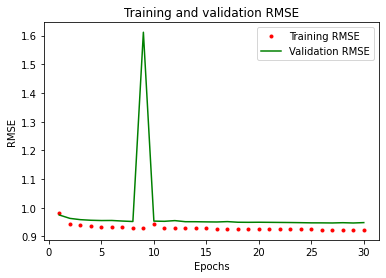

In [30]:
rmse_values = result2.history['root_mean_squared_error']
val_rmse_values = result2.history['val_root_mean_squared_error']

epochs = range(1, len(val_rmse_values)+1 )
plt.plot(epochs, rmse_values, 'r.', label='Training RMSE')
plt.plot(epochs, val_rmse_values, 'g', label='Validation RMSE')
plt.title('Training and validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [33]:
x = layers.Dense(10, activation = 'relu') (inputs)
x = layers.Dense(10, activation = 'relu') (x)
x = layers.Dense(10, activation = 'relu') (x)
x = layers.Dense(10, activation = 'relu') (x)
x = layers.Dense(10, activation = 'relu') (x)
x = layers.Dense(10, activation = 'relu') (x)
x = layers.Dense(n_outputs) (x)
model4 = Model(inputs, x)
model4.compile(loss = 'mse', optimizer='sgd', metrics = [tf.keras.metrics.RootMeanSquaredError()])
result4=model4.fit(X_trainst, y_trainst, batch_size=100, epochs=30, verbose=0,
          validation_data=(X_validationst, y_validationst))

In [34]:
print('RMSE:', result4.history['root_mean_squared_error'][-1])
print('validation RMSE:',result4.history['val_root_mean_squared_error'][-1])

RMSE: 0.9225127100944519
validation RMSE: 0.9465503692626953


If we add too much layers the network doesn't learn well (the validation RMSE becomes big).

### choose best activation function

Now we analize if there is a more performing activation function.

In [ ]:
def NeuralNetwork(X, activation, n_outputs):
    inputs = Input(shape = (X.shape[1])) #T/X/Y/C)
    x = layers.Dense(10, activation = activation) (inputs)
    x = layers.Dense(10, activation = activation) (x)
    x = layers.Dense(n_outputs) (x)
    model = Model(inputs, x)
    model.compile(loss = 'mse', optimizer='sgd', metrics = [tf.keras.metrics.RootMeanSquaredError()]) 
    return model

In [ ]:
# Add the GELU function
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))
get_custom_objects().update({'gelu': Activation(gelu)})

# Add the alpha parameter of the Leaky-Relu function
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

#act_func = ['relu', 'selu']
act_func = ['relu', 'elu', 'selu', 'gelu']

In [ ]:
result = []
for activation in act_func:
    print('\nTraining with -->{0}<-- activation function\n'.format(activation))
    dims = 1
    model = NeuralNetwork(activation=activation, X = X_trainst, n_outputs=dims)
    
    history = model.fit(X_trainMod, y_trainMod,
          epochs=30,
          batch_size=100,
          verbose=0,
          validation_data=(X_validationst, y_validationst))
    
    result.append(history)
    
    K.clear_session()
    del model

In [ ]:
rmse_finale = []

def risultati(activation_function, rmse):
    for i in range(len(activation_function)):
        print('RMSE of the activation function {} is {}'.format(activation_function[i], round(rmse[i], 5)))
        
def plot_act_func_results(results, activation_functions = []):
    plt.figure(figsize=(10,10))
    plt.style.use('dark_background')
    
    # Plot of the validation root mean squared error
    plt.figure(figsize=(10,10))
    
    for act_func in results:
        plt.plot(act_func.history['val_root_mean_squared_error'])
        rmse_finale.append(act_func.history['val_root_mean_squared_error'][-1])
    
    plt.title('Model RMSE')
    plt.ylabel('Validation RMSE')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

plot_act_func_results(result, act_func)

So we confirm the relu as activation function in the input and hidden layers.

# Prevision on the test set
We choose the model 2 as the best performing model.

In [35]:
print_evaluate(y_train['price'],  scaler2.inverse_transform(model2.predict(X_trainst))[:, 0])
print('Standard deviation of the train data:', y_train.std()[0])

RMSE: 200.89487
Standard deviation of the train data: 217.74540295022058


In [40]:
pred=scaler2.inverse_transform(model2.predict(X_testst))[:, 0]
np.savetxt('Laura_Cavenati_864000_score1.txt', np.zeros(10), fmt='%1.1i')

# Comments and conclusion
The best model, model 2 obtains an RMSE of 345. To get an idea of ​​the goodness of the model, we can compare this result with the standard deviation of the train set data which is equal to 217,74. The model is not able to explain well the variability of the data and doesn't predict the price of airbeb housing.  
This can be due to several reasons:  
- Presence of outliers. In this analysis we have chosen not to remove the outliers because it would be useful to ask a domain expert first. Removing these values ​​could lose the ability  of the model to generalize.
- Optimization of parameters: it would be useful to implement more rigorous methods to optimize the model (regularization .).
- More data may be needed for the network to learn better.
- The price of the accommodation may depend on other variables that are not included in the dataset.